# Computer vision

In [55]:
import zipfile
import urllib.request
import random
import os
import pathlib
import numpy as np
import pandas as pd

import matplotlib.pylab as plt
import matplotlib.image as mpimg

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [42]:
# # downloading dataset

# url = "https://storage.googleapis.com/ztm_tf_course/food_vision/pizza_steak.zip"
# filename = "pizza_steak.zip"
# file = urllib.request.urlretrieve(url, filename)


In [43]:
# # unziping dataset

# with zipfile.ZipFile("pizza_steak.zip") as zip_ref:
#     zip_ref.extractall()

## inspect data

In [44]:
for dirpath, dirnames, filenames in os.walk("./pizza_steak/"):
    print(
        f"there are {len(dirnames)} directories and {len(filenames)} images in {dirpath}"
    )


there are 2 directories and 0 images in ./pizza_steak/
there are 2 directories and 0 images in ./pizza_steak/test
there are 0 directories and 250 images in ./pizza_steak/test/steak
there are 0 directories and 250 images in ./pizza_steak/test/pizza
there are 2 directories and 0 images in ./pizza_steak/train
there are 0 directories and 750 images in ./pizza_steak/train/steak
there are 0 directories and 750 images in ./pizza_steak/train/pizza


In [45]:
len(os.listdir("./pizza_steak/train/steak/"))

750

## Visualize

In [46]:
data_dir = pathlib.Path("./pizza_steak/train/")
class_names = np.array(sorted(item.name for item in data_dir.glob("*")))
class_names

array(['pizza', 'steak'], dtype='<U5')

In [47]:
def view_random_image(target_dir, target_class):
    target_folder = target_dir + target_class
    random_image = random.sample(os.listdir((target_folder)), 1)
    img = mpimg.imread(target_folder + "/" + random_image[0])
    plt.imshow(img)
    plt.title(target_class)
    plt.axis("off")

    print(f"Image shape: {img.shape}")

    return img

Image shape: (512, 512, 3)


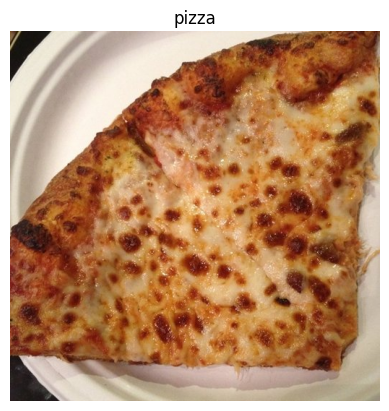

In [48]:
img = view_random_image("./pizza_steak/train/", "pizza")


## Building the cnn nn

In [3]:
tf.random.set_seed(42)
train_datagen = ImageDataGenerator(rescale=1. / 255)
valid_datagen = ImageDataGenerator(rescale=1. / 255)

train_dir = "./pizza_steak/train/"
test_dir = "./pizza_steak/test/"

train_data = train_datagen.flow_from_directory(directory=train_dir,
                                               batch_size=32,
                                               target_size=(224, 224),
                                               class_mode="binary",
                                               seed=42)

valid_data = valid_datagen.flow_from_directory(directory=test_dir,
                                               batch_size=32,
                                               target_size=(224, 224),
                                               class_mode="binary",
                                               seed=42)

# Create a CNN model (same as Tiny VGG - https://poloclub.github.io/cnn-explainer/)
model_1 = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(
        filters=10,
        kernel_size=3,  # can also be (3, 3)
        activation="relu",
        input_shape=(224, 224, 3)
    ),  # first layer specifies input shape (height, width, colour channels)
    tf.keras.layers.Conv2D(10, 3, activation="relu"),
    tf.keras.layers.MaxPool2D(
        pool_size=2,  # pool_size can also be (2, 2)
        padding="valid"),  # padding can also be 'same'
    tf.keras.layers.Conv2D(10, 3, activation="relu"),
    tf.keras.layers.Conv2D(
        10, 3, activation="relu"
    ),  # activation='relu' == tf.keras.layers.Activations(tf.nn.relu)
    tf.keras.layers.MaxPool2D(2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1, activation="sigmoid")  # binary activation output
])

# Compile the model
model_1.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# Fit the model
history_1 = model_1.fit(train_data,
                        epochs=5,
                        steps_per_epoch=len(train_data),
                        validation_data=valid_data,
                        validation_steps=len(valid_data))


Found 1500 images belonging to 2 classes.
Found 500 images belonging to 2 classes.


2023-02-16 16:19:38.886816: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/5
47/47 [==============================] - 50s 1s/step - loss: 0.5877 - accuracy: 0.6633 - val_loss: 0.4020 - val_accuracy: 0.8520
Epoch 2/5
47/47 [==============================] - 51s 1s/step - loss: 0.4089 - accuracy: 0.8233 - val_loss: 0.4040 - val_accuracy: 0.8160
Epoch 3/5
47/47 [==============================] - 51s 1s/step - loss: 0.3804 - accuracy: 0.8260 - val_loss: 0.3658 - val_accuracy: 0.8340
Epoch 4/5
47/47 [==============================] - 50s 1s/step - loss: 0.3409 - accuracy: 0.8613 - val_loss: 0.3040 - val_accuracy: 0.8700
Epoch 5/5
47/47 [==============================] - 50s 1s/step - loss: 0.3010 - accuracy: 0.8753 - val_loss: 0.3403 - val_accuracy: 0.8600


In [4]:
model_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 10)      280       
                                                                 
 conv2d_1 (Conv2D)           (None, 220, 220, 10)      910       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 110, 110, 10)     0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 108, 108, 10)      910       
                                                                 
 conv2d_3 (Conv2D)           (None, 106, 106, 10)      910       
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 53, 53, 10)       0         
 2D)                                                    

<AxesSubplot: >

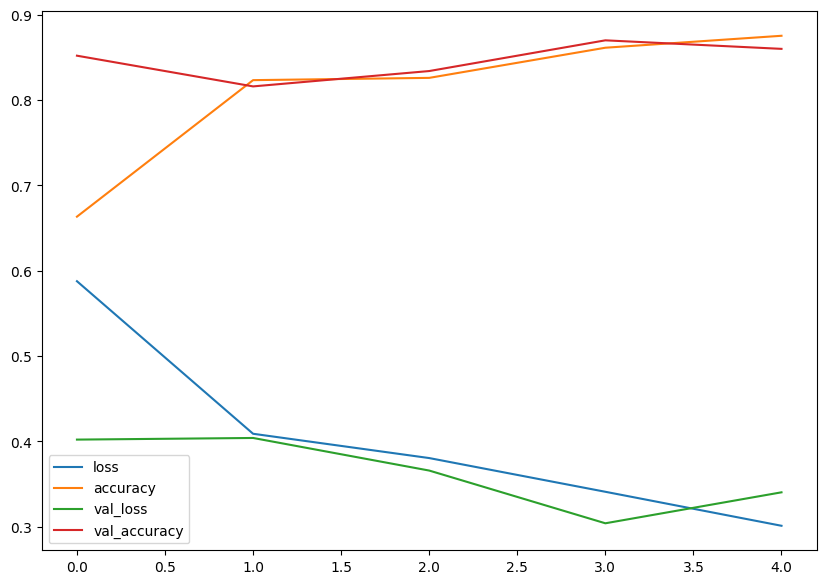

In [11]:
pd.DataFrame(history_1.history).plot(figsize=(10, 7))


In [12]:
def plot_loss_curves(history):
    """
  Returns separate loss curves for training and validation metrics.
  """
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']

    epochs = range(len(history.history['loss']))

    # Plot loss
    plt.plot(epochs, loss, label='training_loss')
    plt.plot(epochs, val_loss, label='val_loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()

    # Plot accuracy
    plt.figure()
    plt.plot(epochs, accuracy, label='training_accuracy')
    plt.plot(epochs, val_accuracy, label='val_accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend()


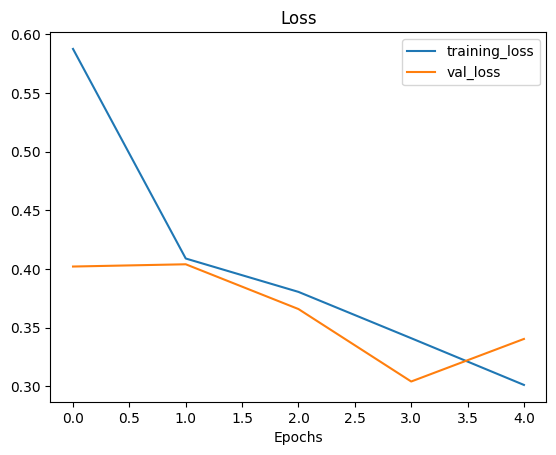

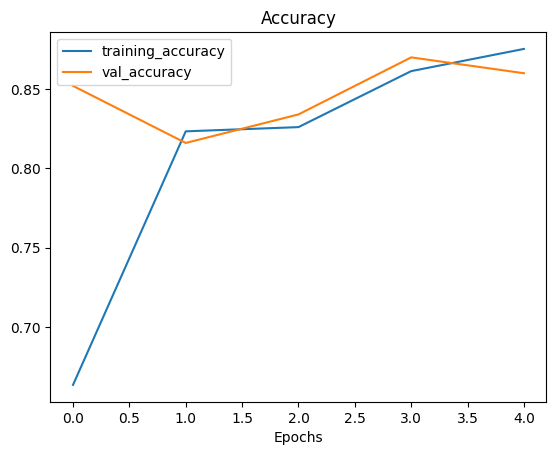

In [13]:
plot_loss_curves(history_1)

## testing on our own steak

In [16]:
url = "https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/03-steak.jpeg"

filename = "steak.jpeg"
file = urllib.request.urlretrieve(url, filename)

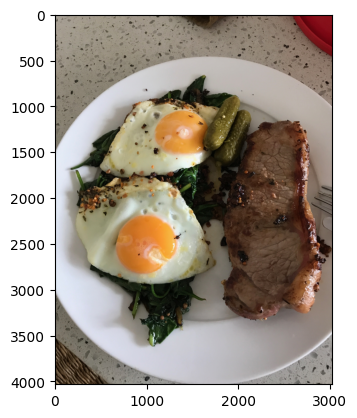

In [19]:
img = mpimg.imread(filename)
plt.imshow(img)

## preprocessing img

In [20]:
def load_and_prep_image(filename, img_shape=224):
    img = tf.io.read_file(filename)
    img = tf.image.decode_image(img)
    img = tf.image.resize(img, size=[img_shape, img_shape])
    img = img / 255.
    return img

In [21]:
steak = load_and_prep_image(filename)

In [23]:
model_1.predict(tf.expand_dims(steak, axis=0))


1/1 [==============================] - 0s 215ms/step


array([[0.86936665]], dtype=float32)

# multiclass img classification

In [25]:
url = "https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip"

filename = "10_food_classes_all_data.zip"
file = urllib.request.urlretrieve(url, filename)

with zipfile.ZipFile("10_food_classes_all_data.zip") as zip_ref:
    zip_ref.extractall()

In [68]:
train_dir = "10_food_classes_all_data/train/"
test_dir = "10_food_classes_all_data/test/"

data_dir = pathlib.Path(train_dir)
class_names = np.array(sorted([item.name for item in data_dir.glob("*")]))
print(class_names)

['chicken_curry' 'chicken_wings' 'fried_rice' 'grilled_salmon' 'hamburger'
 'ice_cream' 'pizza' 'ramen' 'steak' 'sushi']


Image shape: (384, 512, 3)


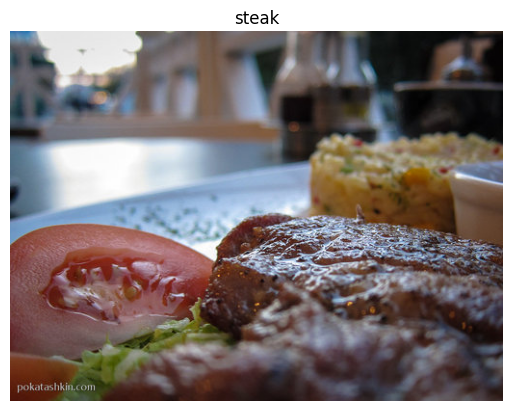

In [49]:
img = view_random_image(train_dir, random.choice(class_names))


In [60]:
tf.random.set_seed(42)
train_datagen = ImageDataGenerator(rescale=1. / 255)
valid_datagen = ImageDataGenerator(rescale=1. / 255)

train_dir = "./10_food_classes_all_data/train/"
test_dir = "./10_food_classes_all_data/test/"

train_data = train_datagen.flow_from_directory(directory=train_dir,
                                               batch_size=32,
                                               target_size=(224, 224),
                                               class_mode="categorical",
                                               seed=42)

test_data = valid_datagen.flow_from_directory(directory=test_dir,
                                              batch_size=32,
                                              target_size=(224, 224),
                                              class_mode="categorical",
                                              seed=42)

# Create a CNN model (same as Tiny VGG - https://poloclub.github.io/cnn-explainer/)
model_2 = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(
        filters=10,
        kernel_size=3,  # can also be (3, 3)
        activation="relu",
        input_shape=(224, 224, 3)
    ),  # first layer specifies input shape (height, width, colour channels)
    tf.keras.layers.Conv2D(10, 3, activation="relu"),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Conv2D(10, 3, activation="relu"),
    tf.keras.layers.Conv2D(10, 3, activation="relu"),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(10, activation="softmax")
])

# Compile the model
model_2.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# Fit the model
history_2 = model_2.fit(train_data,
                        epochs=5,
                        steps_per_epoch=len(train_data),
                        validation_data=test_data,
                        validation_steps=len(test_data))


Found 7500 images belonging to 10 classes.
Found 2500 images belonging to 10 classes.
Epoch 1/5
235/235 [==============================] - 236s 998ms/step - loss: 2.1445 - accuracy: 0.2216 - val_loss: 1.9887 - val_accuracy: 0.3016
Epoch 2/5
235/235 [==============================] - 237s 1s/step - loss: 1.8609 - accuracy: 0.3532 - val_loss: 1.9166 - val_accuracy: 0.3292
Epoch 3/5
235/235 [==============================] - 238s 1s/step - loss: 1.4810 - accuracy: 0.5005 - val_loss: 2.0399 - val_accuracy: 0.3044
Epoch 4/5
235/235 [==============================] - 245s 1s/step - loss: 0.9066 - accuracy: 0.7008 - val_loss: 2.5294 - val_accuracy: 0.2620
Epoch 5/5
235/235 [==============================] - 238s 1s/step - loss: 0.3932 - accuracy: 0.8763 - val_loss: 3.6280 - val_accuracy: 0.2788


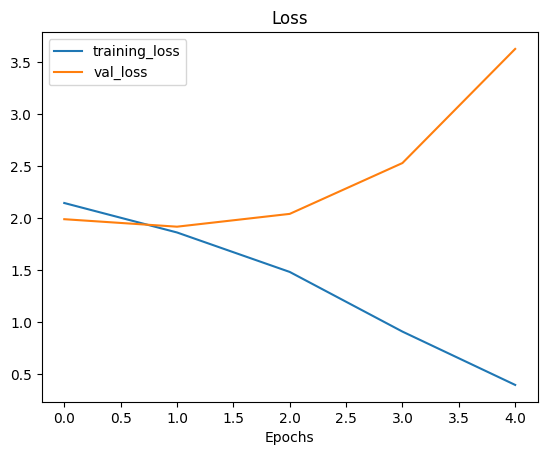

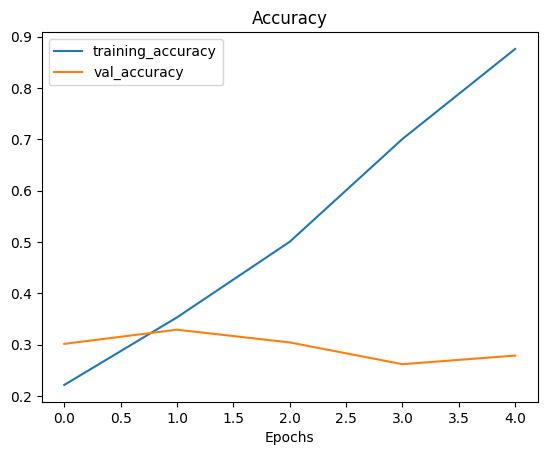

In [61]:
plot_loss_curves(history_2)

## model_2 is overfit, need to tune model

In [62]:
model_3 = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(10, 3, activation="relu",
                           input_shape=(224, 224, 3)),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Conv2D(10, 3, activation="relu"),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(10, activation="softmax")
])

model_3.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

history_3 = model_3.fit(train_data,
                        epochs=5,
                        steps_per_epoch=len(train_data),
                        validation_data=test_data,
                        validation_steps=len(test_data))

im not ganna run the above cell cuz it takes 20 mins and plus imma use augmented data below

In [63]:
train_datagen_augmented = ImageDataGenerator(rescale=1 / 255.,
                                             rotation_range=20,
                                             width_shift_range=0.2,
                                             height_shift_range=0.2,
                                             zoom_range=0.2,
                                             horizontal_flip=True)

train_data_augmented = train_datagen_augmented.flow_from_directory(
    train_dir, target_size=(224, 224), batch_size=32, class_mode='categorical')


Found 7500 images belonging to 10 classes.


In [64]:
model_4 = tf.keras.models.clone_model(model_3)

model_4.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

history_4 = model_4.fit(train_data_augmented,
                        epochs=5,
                        steps_per_epoch=len(train_data_augmented),
                        validation_data=test_data,
                        validation_steps=len(test_data))

Epoch 1/5
235/235 [==============================] - 187s 790ms/step - loss: 2.2416 - accuracy: 0.1680 - val_loss: 2.1604 - val_accuracy: 0.2116
Epoch 2/5
235/235 [==============================] - 178s 755ms/step - loss: 2.1098 - accuracy: 0.2504 - val_loss: 1.9990 - val_accuracy: 0.2876
Epoch 3/5
235/235 [==============================] - 180s 767ms/step - loss: 2.0549 - accuracy: 0.2684 - val_loss: 1.9754 - val_accuracy: 0.2956
Epoch 4/5
235/235 [==============================] - 182s 772ms/step - loss: 2.0105 - accuracy: 0.2996 - val_loss: 1.8791 - val_accuracy: 0.3468
Epoch 5/5
235/235 [==============================] - 184s 783ms/step - loss: 1.9870 - accuracy: 0.3027 - val_loss: 1.9188 - val_accuracy: 0.3336


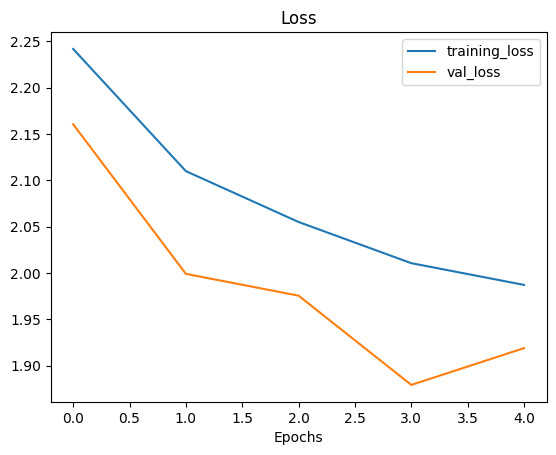

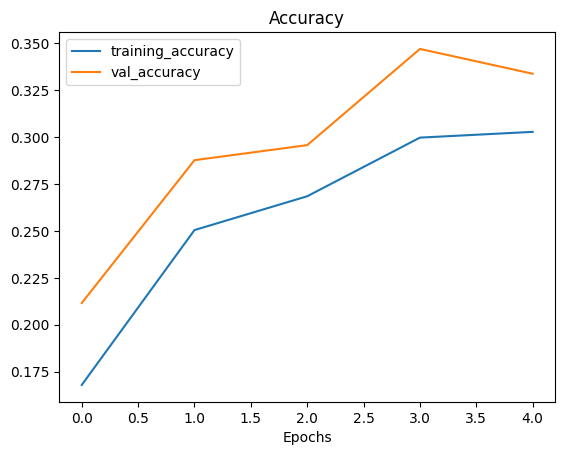

In [66]:
plot_loss_curves(history_4)

In [71]:
model_4.save("saved_model_4")

INFO:tensorflow:Assets written to: saved_model_4/assets


INFO:tensorflow:Assets written to: saved_model_4/assets
